In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import torch
import torch.nn as nn

import model
import random

import os
from matplotlib import pyplot as plt
import Augment
import imageProcessing as ip
import csv

from Config import Config

In [41]:
def split_data(data, test_size=0.2, random_seed=None):
    """
    Splits a list of dictionaries into training and test datasets.
    
    Parameters:
        data (list of dict): The input data to be split.
        test_size (float): Proportion of the dataset to include in the test split (default is 0.2).
        random_seed (int, optional): Random seed for reproducibility (default is None).
    
    Returns:
        tuple: (train_data, test_data) where both are lists of dictionaries.
    """
    if random_seed is not None:
        random.seed(random_seed)
    
    # Shuffle the data
    shuffled_data = data[:]
    random.shuffle(shuffled_data)
    
    # Compute the split index
    split_idx = int(len(shuffled_data) * (1 - test_size))
    
    # Split the data
    train_data = shuffled_data[:split_idx]
    test_data = shuffled_data[split_idx:]
    
    return train_data, test_data

In [42]:
# Open the CSV file and read its contents into a dictionary
# The stored data is: picture_name, x1, y1, x2, y2 
with open(Config.coords_file_path, mode='r') as file:
    reader = csv.DictReader(file)  # Use DictReader to automatically map rows to dictionaries
    data = [row for row in reader]  # Convert each row into a dictionary and store in a list

train_data, test_data = split_data(data)
print(len(train_data), len(test_data))

1919 480


In [43]:
image_names = [filename for filename in os.listdir(Config.images_folder_path) if filename.endswith(".jpg") or filename.endswith(".png")]

In [44]:
# Set the device to MPS (Metal Performance Shaders). If non-mac usage, try cuda
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Training on device: {device}")

Training on device: mps


In [48]:
kpd_model = model.KeypointDetectionModel().to(device)

model.train_kpd_model(kpd_model, train_data, test_data, 50, 100, 250)

Epoch 0: test loss = 0.0979941189289093, lr = 9.900000000000001e-05
Epoch 50: test loss = 0.005464072804898024, lr = 5.9895600646616125e-05
Epoch 100: test loss = 0.00278271222487092, lr = 3.62372017860497e-05
Epoch 150: test loss = 0.003355777822434902, lr = 2.1923726936647233e-05
Epoch 200: test loss = 0.002825740724802017, lr = 1.326398781093821e-05


In [50]:
import ConfidenceModel

kpd_model.eval()
conf_model = ConfidenceModel.ConfidenceModel().to(device)

ConfidenceModel.train_conf_model(conf_model, kpd_model, train_data, test_data, 50, 100, 81, feedback_rate=10)

Epoch 0: test loss = 8.971955685410649e-05, lr = 9.9e-06
Epoch 20: test loss = 5.40608489245642e-05, lr = 8.097278682212583e-06
Epoch 40: test loss = 8.650012750877067e-05, lr = 6.622820409839832e-06


KeyboardInterrupt: 

In [28]:
import ConfidenceModel

kpd_model.eval()

conf_best_test_loss = 10

conf_model = ConfidenceModel.ConfidenceModel().to(device)
conf_batchsize = 100
conf_test_batchsize = 100

conf_criterion = nn.MSELoss()  # Loss for regression
conf_optimizer = torch.optim.Adam(conf_model.parameters(), lr=1e-5)

conf_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(conf_optimizer, lr_lambda=lambda epoch: 0.99)

conf_model.train()

for epoch in range(150):
    images, errors, names = ConfidenceModel.get_batch(train_data, kpd_model, batchsize=conf_batchsize, augment_images=True, device = device)  
    # Move the data to the MPS device
    images = images.to(device)
    errors = errors.to(device)
    conf_optimizer.zero_grad()
    outputs = conf_model(images)  # Forward pass
    loss = conf_criterion(outputs, errors)  # Compute loss
    loss.backward()  # Backpropagation
    conf_optimizer.step()  # Update weights
    conf_scheduler.step() # Update LR 

    if not epoch%15:
        with torch.no_grad():
            conf_model.eval()
            images, errors, names = ConfidenceModel.get_batch(test_data, kpd_model, batchsize=conf_test_batchsize, augment_images = False, device = device)  
            # Move the data to the MPS device
            images = images.to(device)
            errors = errors.to(device)
            #optimizer.zero_grad()
            outputs = conf_model(images)  # Forward pass
            test_loss = conf_criterion(outputs, errors)  # Compute loss
            current_lr = conf_optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch}: test loss = {test_loss}, lr = {current_lr}")

            conf_model.train()
    
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_conf_model_state = conf_model.state_dict()

Epoch 0: test loss = 0.004420624580234289, lr = 9.9e-06
Epoch 15: test loss = 0.00023973514907993376, lr = 8.514577710948753e-06
Epoch 30: test loss = 5.3087136620888487e-05, lr = 7.323033696543972e-06
Epoch 45: test loss = 9.11029928829521e-06, lr = 6.29823631203232e-06
Epoch 60: test loss = 2.046756708296016e-05, lr = 5.416850759668533e-06
Epoch 75: test loss = 2.383332684985362e-05, lr = 4.658807751697933e-06


KeyboardInterrupt: 

In [29]:
"""
Plot keypoint detection model prediction side by side with expected keypoints
"""
def plot_conf_model_prediction(kpd_model, data, n_images, conf_model = None, estimated_error_interval = [-1, 1], augment_images = False, device=None):

    # Set model to evaluation mode (disables dropout, batchnorm, etc.)
    kpd_model.eval()

    # Sample n_images images to plot
    for image_data in random.sample(data, n_images):

        # Get image path. All images without bachground for the model are .png, so we need to change the suffix
        name = image_data["Image Name"]
        img_path = os.path.join(Config.images_folder_path + "/", name)
        base, _ = os.path.splitext(img_path)
        img_path = f"{base}.png"

        # Get keypoints
        x1, y1 = image_data["x1"], image_data["y1"]
        x2, y2 = image_data["x2"], image_data["y2"]

        # Prepare image and keypoints for the model
        img, keypoints = Augment.prepare_for_model(img_path, [(x1, y1), (x2, y2)], augment_images=augment_images)
        x, _ = model.to_xy(img, keypoints)
        # We somehow have to unsqueeze twice, could be worth investigating
        x_tensor = x.unsqueeze(0).unsqueeze(0).to(device)  # Move to the correct device (MPS or CPU)
        
        # Forward pass on the model
        with torch.no_grad():  # No gradients needed for inference
            pred = kpd_model(x_tensor)

        # Post-processing of the model output (e.g., rescale the coords which are outputed between 0 and 1)
        """
        This is completely messed up but somehow we have to switch x and y (it should be x1, y1, x2, y2 = ...)
        Somewhere in the code x and y were already switched, we need to find where...
        """
        y1pred, x1pred, y2pred, x2pred = pred[0][0].item() * Config.input_image_shape[0], pred[0][1].item() * Config.input_image_shape[1], pred[0][2].item() * Config.input_image_shape[0], pred[0][3].item() * Config.input_image_shape[1]

        #img, keypoints = Augment.prepare_for_model(img_path, [(x1, y1), (x2, y2)])
        
        # If len(keypoints) != 2, then the augmentation lost a keypoint (too much rotation for example) and we are not interested
        if len(keypoints) == 2:

            if conf_model is None:
                display = True
            else:
                conf_model.eval()
                with torch.no_grad():
                    error_pred = conf_model(x_tensor)
                    min_error, max_error = estimated_error_interval[0], estimated_error_interval[1]
                    display = True if (min_error <= error_pred and error_pred <= max_error) else False
            
            if display:
                print("Error estimation = ", error_pred.item())
                
                # Add keypoints and prediction to the image and plot
                with_y = ip.add_point_channels(img, keypoints[0], keypoints[1])
                with_pred = ip.add_point_channels(img, (int(x1pred), int(y1pred)), (int(x2pred), int(y2pred)))

                # Plot side-by-side
                plt.figure(figsize=(10, 5))  # Set the figure size

                # First image
                plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
                plt.imshow(with_y)  # Display the first image
                plt.title("Expected")
                plt.axis('off')  # Turn off axes for better visual effect

                # Second image
                plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
                plt.imshow(with_pred)  # Display the second image
                plt.title("Prediction")
                plt.axis('off')

                # Display the plot
                plt.tight_layout()  # Adjust spacing
                plt.show()

                

Confident predictions:
Error estimation =  0.0013347221538424492


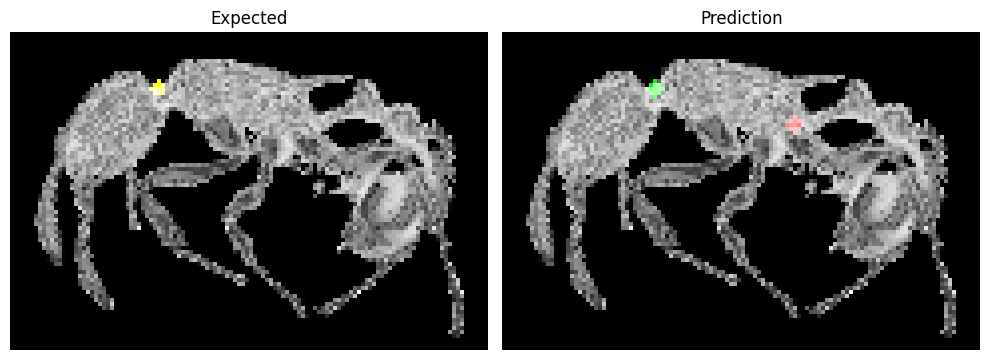

Error estimation =  -0.0004947707056999207


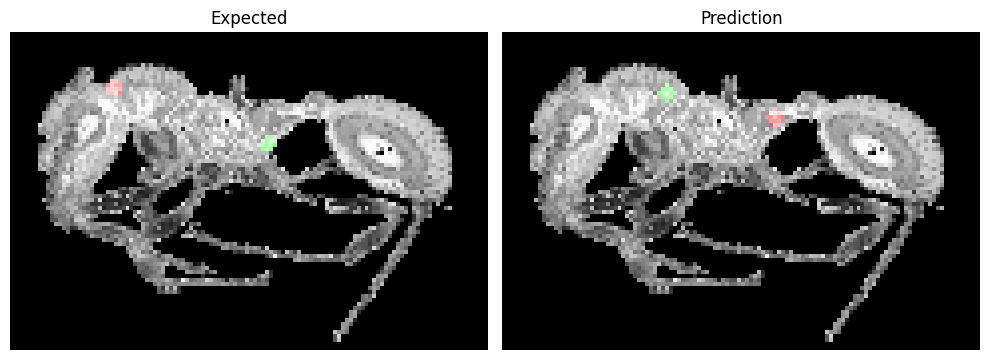

Error estimation =  0.0007387744262814522


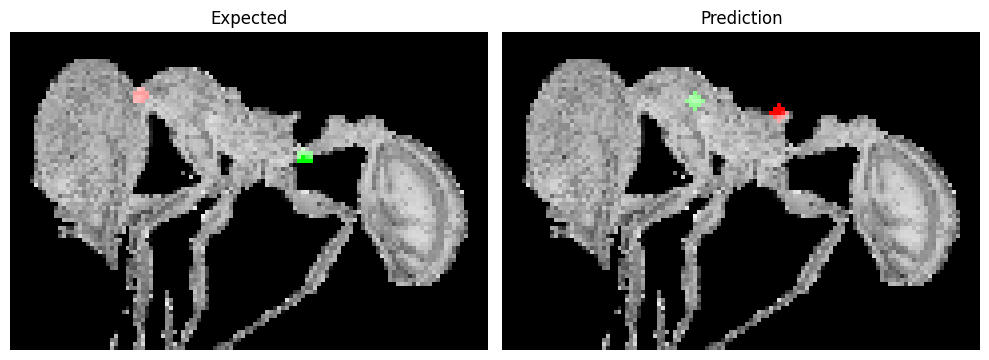

Error estimation =  0.0017417091876268387


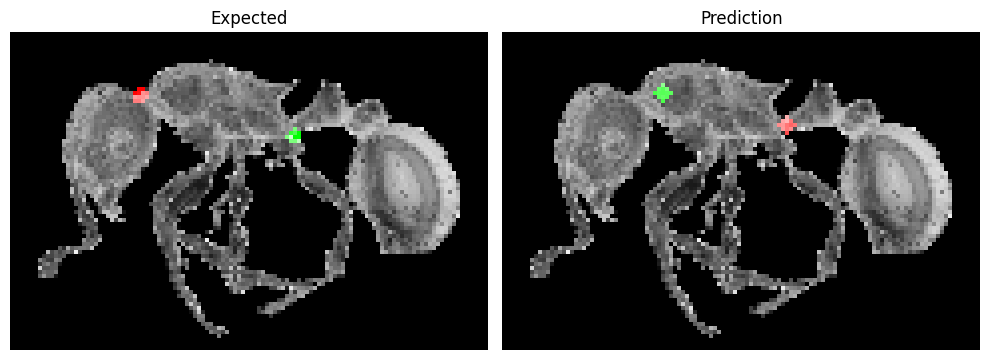

Error estimation =  0.0018721390515565872


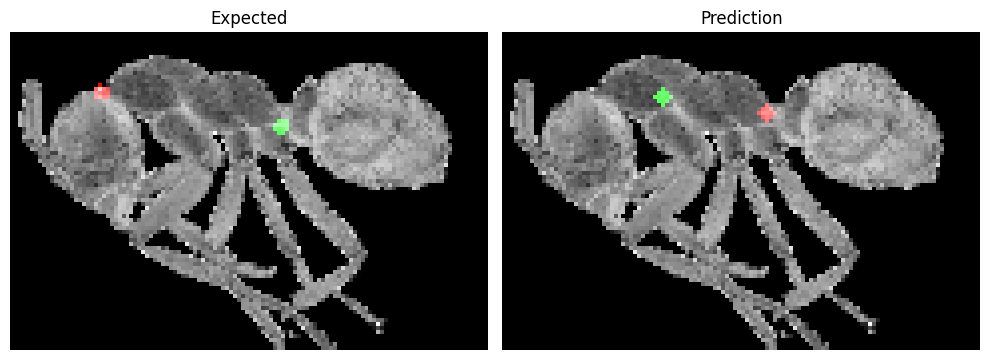

Error estimation =  0.0016421722248196602


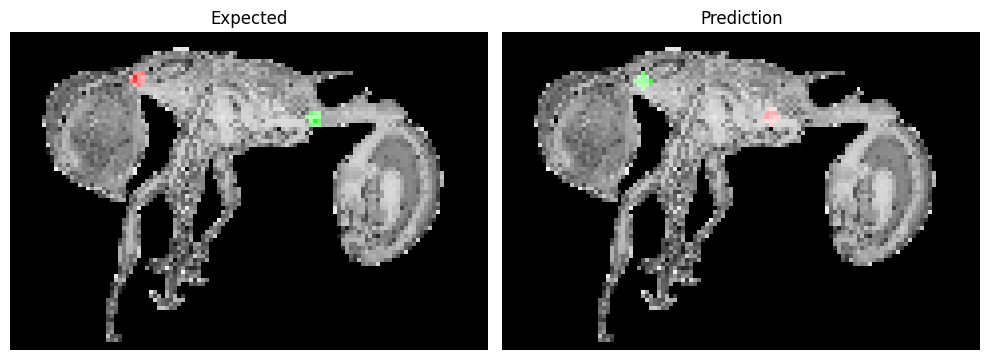

Error estimation =  0.0017811702564358711


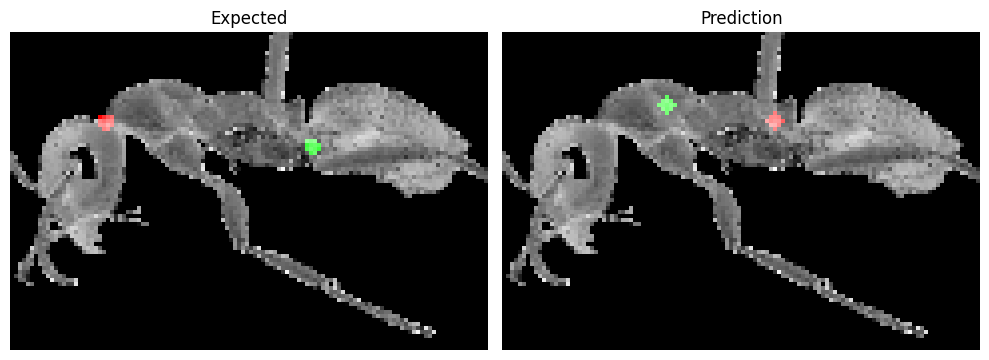

Error estimation =  0.0011296877637505531


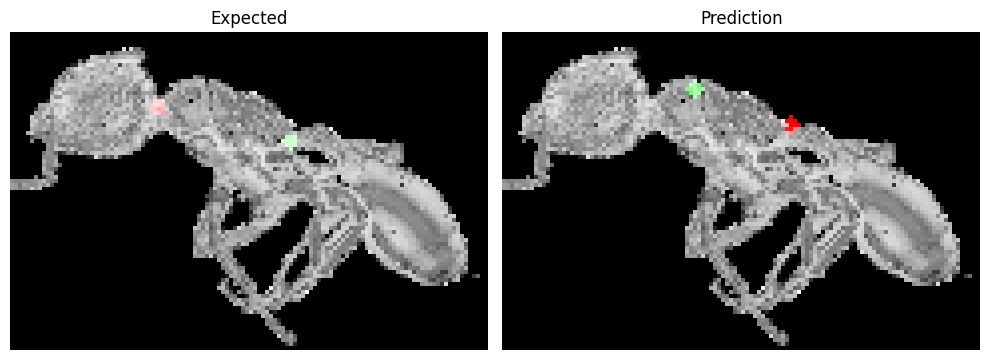

Error estimation =  0.000973578542470932


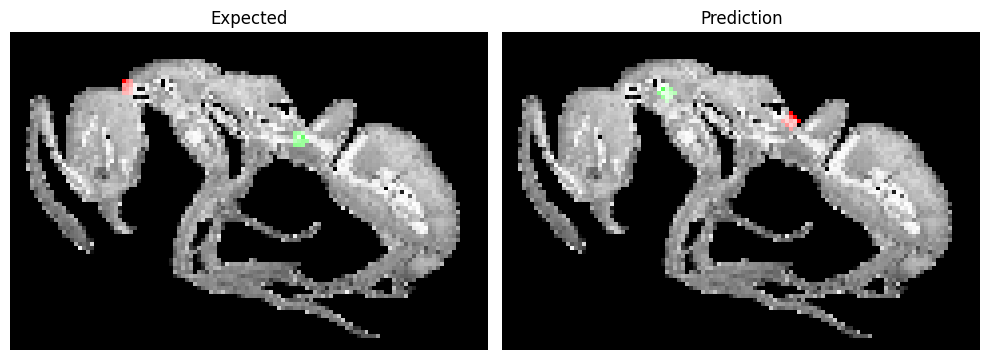

Error estimation =  0.0011692438274621964


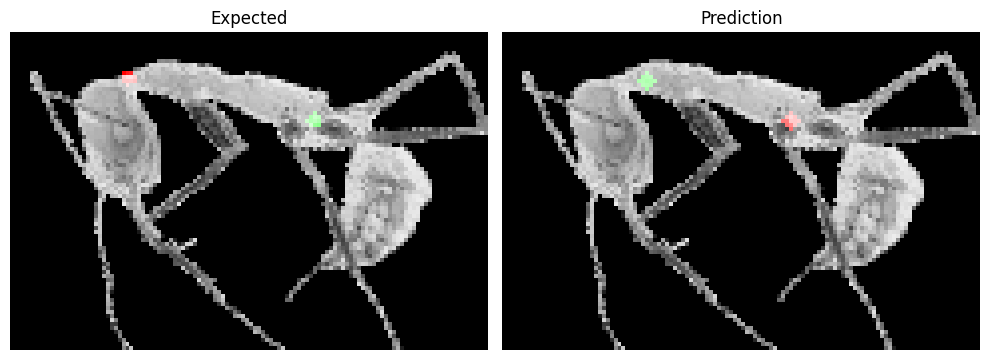

Error estimation =  0.0011257212609052658


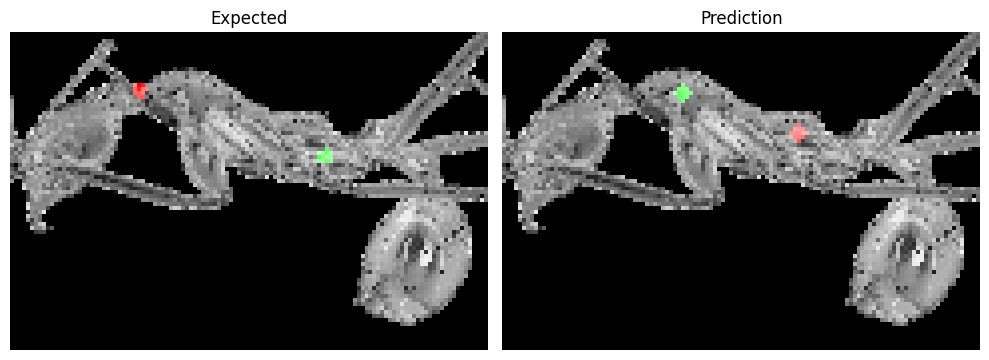

Error estimation =  -0.0004197126254439354


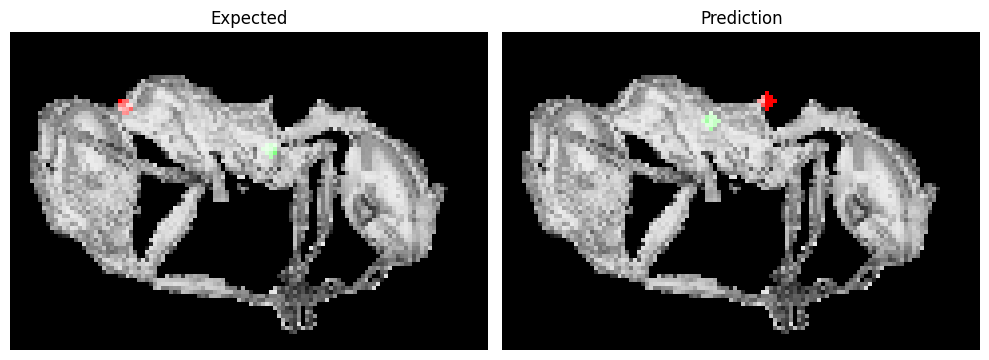

Error estimation =  0.0001888340339064598


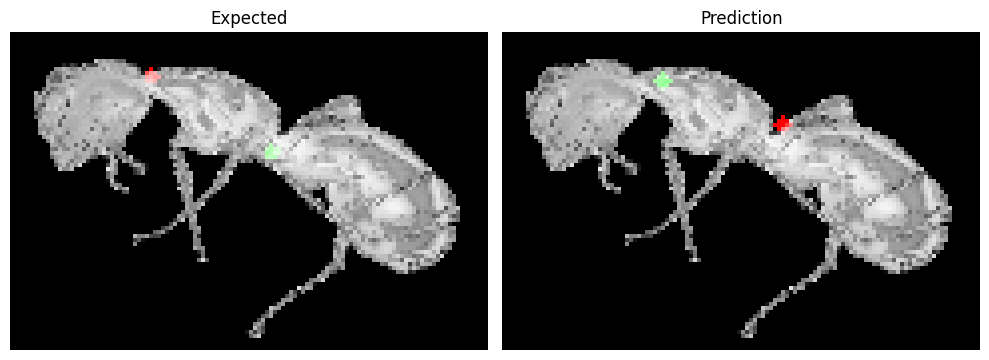

Error estimation =  0.001825389452278614


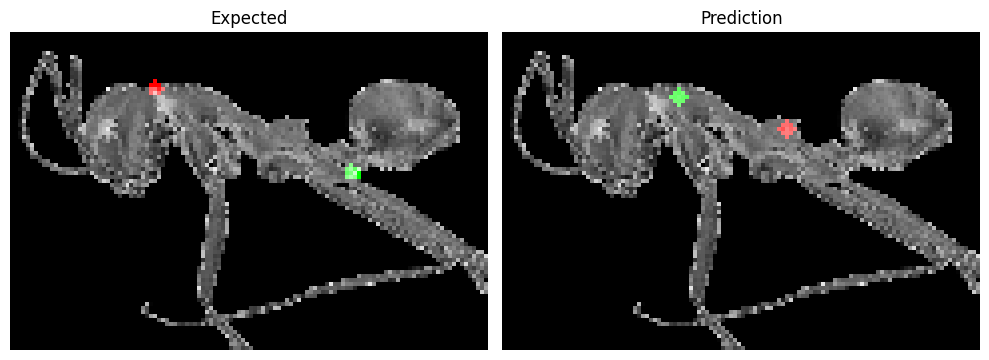

Error estimation =  0.0012432588264346123


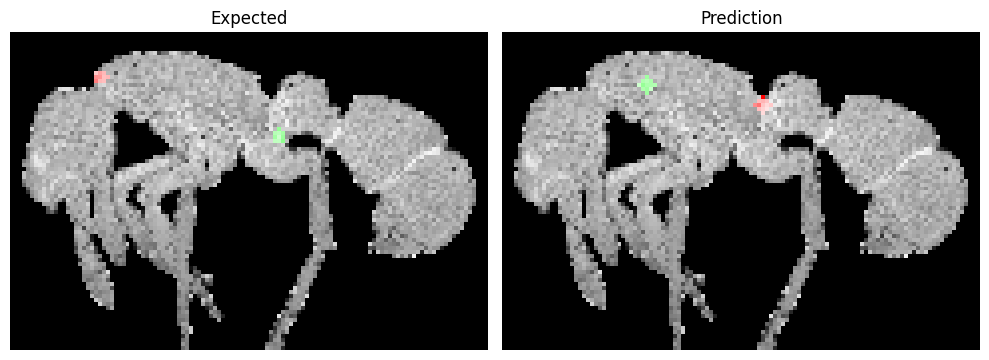

Error estimation =  0.0017291372641921043


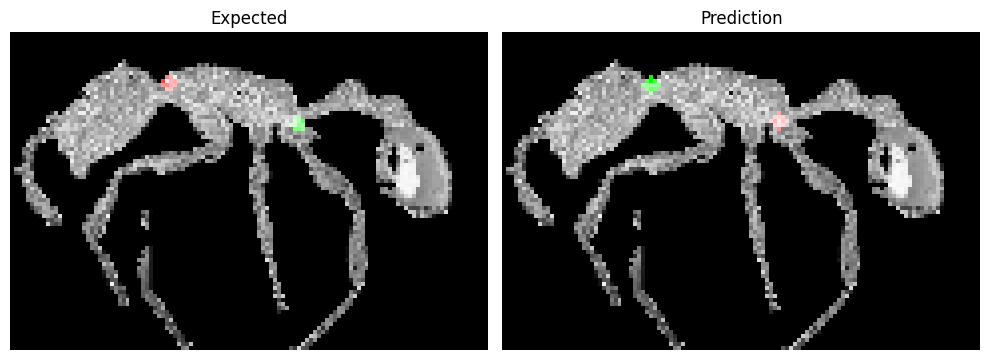

In [30]:
conf_model.load_state_dict(best_conf_model_state)
kpd_model.eval()
conf_model.eval()

print("Confident predictions:")
plot_conf_model_prediction(kpd_model, test_data, 50, conf_model = conf_model, estimated_error_interval= [-1, 0.002],augment_images=False, device="mps")

Non-confident predictions:
Error estimation =  0.005255022086203098


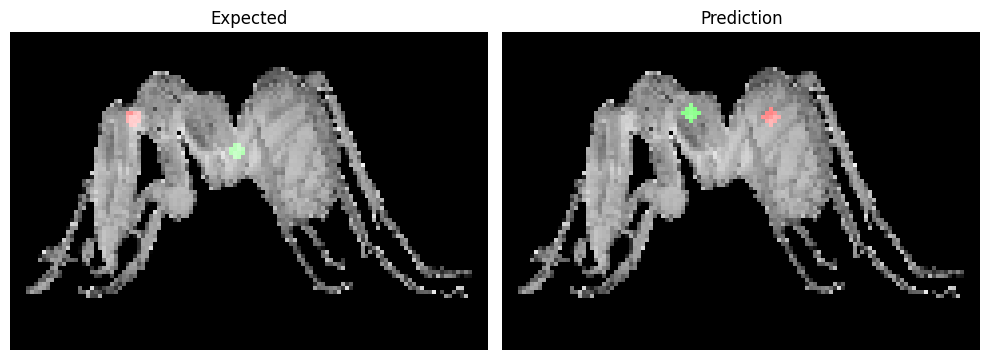

Error estimation =  0.0055624572560191154


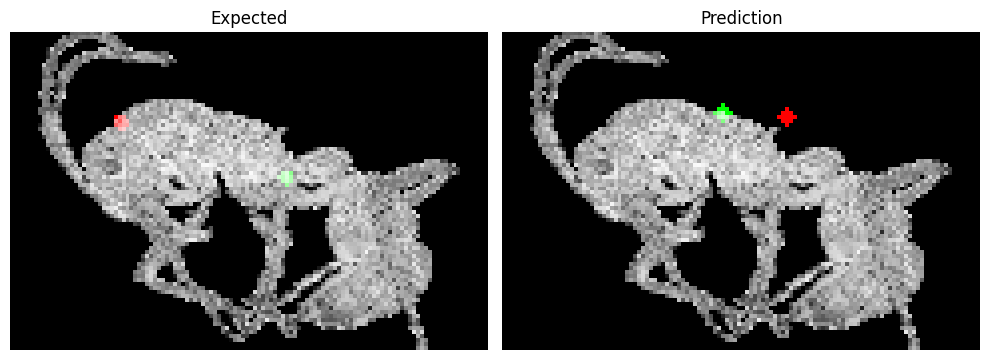

Error estimation =  0.010130706243216991


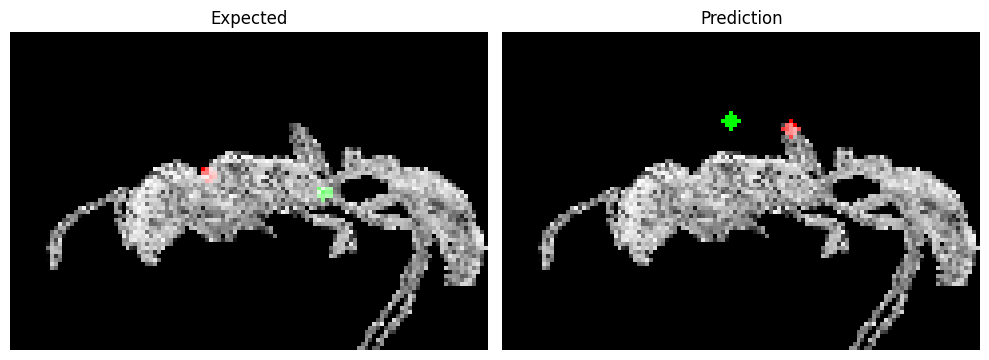

Error estimation =  0.00633020605891943


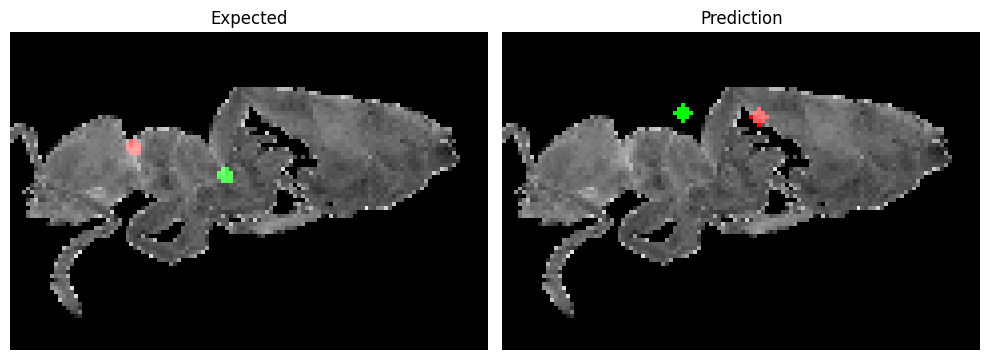

Error estimation =  0.005946223624050617


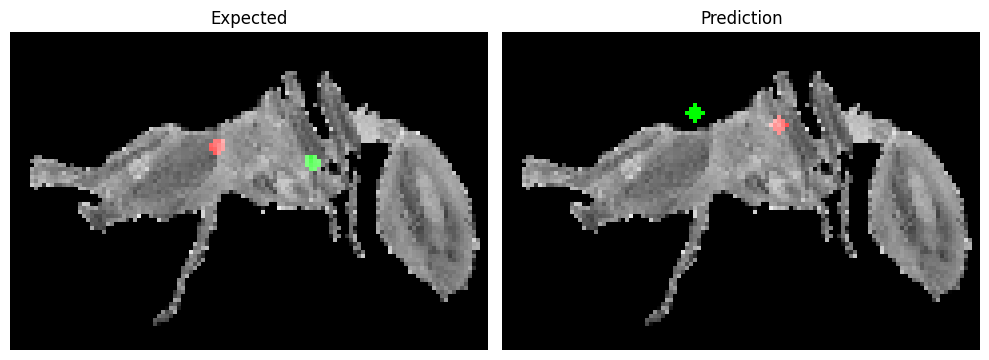

Error estimation =  0.00574574526399374


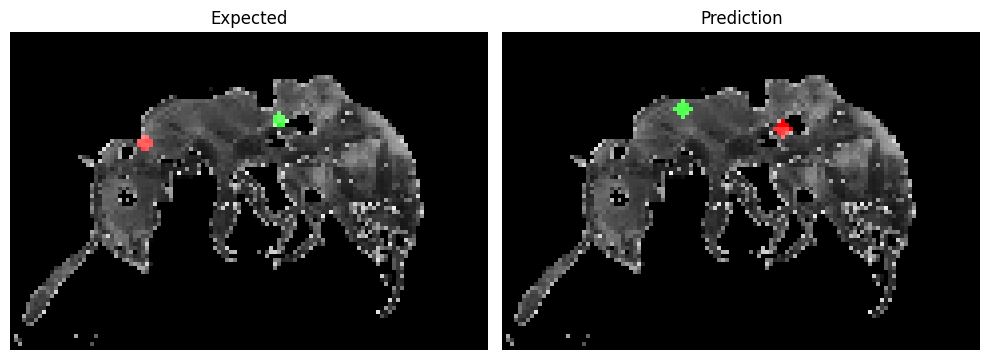

Error estimation =  0.0050591519102454185


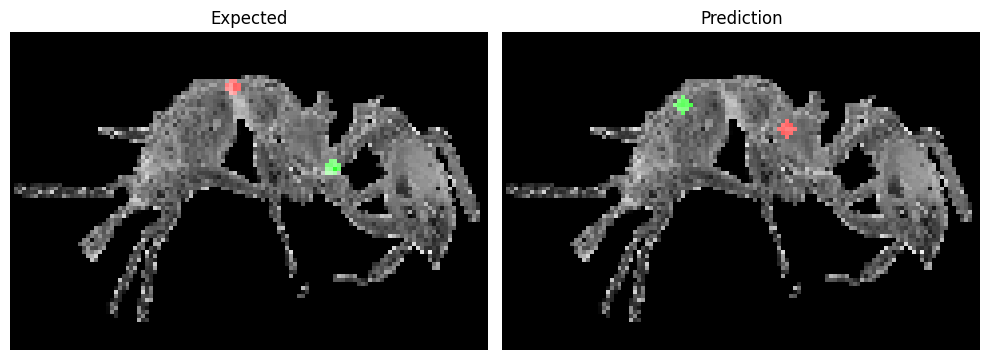

In [31]:
print("Non-confident predictions:")
plot_conf_model_prediction(kpd_model, test_data, 50, conf_model = conf_model, estimated_error_interval= [0.005, 1],augment_images=False, device="mps")